In [ ]:

from google.colab import drive
drive.mount('/content/gdrive')

#torchdata==0.3.0 torchtext==0.12 spacy==3.2 altair datasets
!pip install -q  GPUtil pickle

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
  Preparing metadata (setup.py) ... done
ERROR: Could not find a version that satisfies the requirement pickle (from versions: none)
ERROR: No matching distribution found for pickle


In [ ]:
import torch


class Configs:
    def __init__(self):
        pass


configs = Configs()

# trainer relatedconfigs.n_cpu = 0
configs.device = torch.device('cuda:0')
configs.batch_size_test = 100
configs.batch_size = 8
#configs.lr = 0.001
configs.weight_decay = 0.0000
configs.display_interval = 120
configs.num_epochs = 100
configs.early_stopping = True
configs.patience = 5#3
configs.gradient_clipping = True # false
configs.clipping_threshold = 1.

# lr warmup
configs.warmup = 3000

# data related
configs.input_dim = 1 # 4
configs.output_dim = 1

configs.input_length = 12
configs.output_length = 26

configs.input_gap = 1
configs.pred_shift = 24

# model
configs.d_model = 256
configs.patch_size = (2, 3)
configs.emb_spatial_size = 12*16
configs.nheads = 4
configs.dim_feedforward = 512
configs.dropout = 0.05
configs.num_encoder_layers = 2#3
configs.num_decoder_layers = 2#3

configs.ssr_decay_rate = 3.e-4 #3.e-4  ssr_decay_rate aumentar empeora a negativo

In [ ]:
#trainer = Trainer(configs)
#total_params = sum(p.numel() for p in trainer.network.parameters() if p.requires_grad)
#print(f"Total trainable parameters: {total_params}")



In [ ]:
"""
Author: Jiacheng WU
Modified by Tito Lasanta
The idea is mainly from Transformer (https://arxiv.org/abs/1706.03762),
and TimeSformer (https://arxiv.org/abs/2102.05095).
We novelly modified the TimeSformer for spatio-temporal prediction.
"""

from datetime import datetime

import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import copy


class SpaceTimeTransformer(nn.Module):
    def __init__(self, configs):
        super().__init__()
        self.configs = configs
        d_model = configs.d_model
        self.device = configs.device
        self.input_dim = configs.input_dim * configs.patch_size[0] * configs.patch_size[1]
        self.src_emb = input_embedding(self.input_dim, d_model, configs.emb_spatial_size,
                                       configs.input_length, self.device)
        self.tgt_emb = input_embedding(self.input_dim, d_model, configs.emb_spatial_size,
                                       configs.output_length, self.device)

        encoder_layer = EncoderLayer(d_model, configs.nheads, configs.dim_feedforward, configs.dropout)
        decoder_layer = DecoderLayer(d_model, configs.nheads, configs.dim_feedforward, configs.dropout)
        self.encoder = Encoder(encoder_layer, num_layers=configs.num_encoder_layers)
        self.decoder = Decoder(decoder_layer, num_layers=configs.num_decoder_layers)
        self.linear_output = nn.Linear(d_model, self.input_dim)

    def forward(self, src, tgt, src_mask=None, memory_mask=None,
                train=True, ssr_ratio=0):
        """
        Args:
            src: (N, T_src, C, H, W)
            tgt: (N, T_tgt, C, H, W), T_tgt is 1 during test
            src_mask: (T_src, T_src)
            tgt_mask: (T_tgt, T_tgt)
            memory_mask: (T_tgt, T_src)
        Returns:
            sst_pred: (N, T_tgt, H, W)
            nino_pred: (N, 24)
        """
        memory = self.encode(src, src_mask)
        if train:
            with torch.no_grad():
                # tgt = torch.cat([src[:, -1:], tgt[:, :-1]], dim=1)  # (N, T_tgt, C, H, W)
                tgt_mask = self.generate_square_subsequent_mask(tgt.size(1))
                sst_pred = self.decode(torch.cat([src[:, -1:], tgt[:, :-1]], dim=1),
                                       memory, tgt_mask, memory_mask)  # (N, T_tgt, C, H, W)

            if ssr_ratio > 1e-6:
                teacher_forcing_mask = torch.bernoulli(ssr_ratio *
                        torch.ones(tgt.size(0), tgt.size(1) - 1, 1, 1, 1)).to(self.device)
            else:
                teacher_forcing_mask = 0
            tgt = teacher_forcing_mask * tgt[:, :-1] + (1 - teacher_forcing_mask) * sst_pred[:, :-1]
            tgt = torch.cat([src[:, -1:], tgt], dim=1)
            sst_pred = self.decode(tgt, memory, tgt_mask, memory_mask)
        else:
            if tgt is None:
                tgt = src[:, -1:]  # use last src as the input during test
            else:
                assert tgt.size(1) == 1
            for t in range(self.configs.output_length):
                tgt_mask = self.generate_square_subsequent_mask(tgt.size(1))
                sst_pred = self.decode(tgt, memory, tgt_mask, memory_mask)
                tgt = torch.cat([tgt, sst_pred[:, -1:]], dim=1)

        sst_pred = sst_pred[:, :, 0]  # (N, T_tgt, H, W)
        nino_pred = sst_pred[:, :, 10:13, 19:30].mean(dim=[2, 3])  # (N, 26)
        nino_pred = nino_pred.unfold(dimension=1, size=3, step=1).mean(dim=2)  # (N, 24)

        return sst_pred, nino_pred

    def encode(self, src, src_mask):
        """
        Args:
            src: (N, T_src, C, H, W)
            src_mask: (T_src, T_src)
        Returns:
            memory: (N, S, T_src, D)
        """
        T = src.size(1)
        src = unfold_StackOverChannel(src, self.configs.patch_size)  # (N, T_src, C_, H_, W_)
        src = src.reshape(src.size(0), T, self.input_dim, -1).permute(0, 3, 1, 2)  # (N, S, T_src, C_)
        src = self.src_emb(src)  # (N, S, T_src, D)
        memory = self.encoder(src, src_mask)  # (N, S, T_src, D)
        return memory

    def decode(self, tgt, memory, tgt_mask, memory_mask):
        """
        Args:
            tgt: (N, T_tgt, C, H, W)
            memory: (N, S, T_src, D)
            tgt_mask: (T_tgt, T_tgt)
            memory_mask: (T_tgt, T_src)
        Returns:
            (N, T_tgt, C, H, W)
        """
        H, W = tgt.size()[-2:]
        T = tgt.size(1)
        tgt = unfold_StackOverChannel(tgt, self.configs.patch_size)  # (N, T_tgt, C_, H_, W_)
        tgt = tgt.reshape(tgt.size(0), T, self.input_dim, -1).permute(0, 3, 1, 2)  # (N, S, T_tgt, C_)
        tgt = self.tgt_emb(tgt)  # (N, S, T_tgt, D)
        output = self.decoder(tgt, memory, tgt_mask, memory_mask)
        output = self.linear_output(output).permute(0, 2, 3, 1)  # (N, T_tgt, C_, S)

        # (N, T_tgt, C_, H_, W_)
        output = output.reshape(tgt.size(0), T, self.input_dim,
                                H // self.configs.patch_size[0], W // self.configs.patch_size[1])
        # (N, T_tgt, C, H, W)
        output = fold_tensor(output, output_size=(H, W), kernel_size=self.configs.patch_size)
        return output

    def generate_square_subsequent_mask(self, sz: int):
        """
        Generate a square mask for the sequence. The masked positions are filled with float('-inf')
        """
        mask = (torch.triu(torch.ones(sz, sz)) == 0).T
        return mask.to(self.configs.device)


class Encoder(nn.Module):
    def __init__(self, encoder_layer, num_layers):
        super().__init__()
        #self.layers = nn.ModuleList([copy.deepcopy(encoder_layer) for _ in range(num_layers)])
        self.layers = nn.ModuleList([encoder_layer for _ in range(num_layers)])

    def forward(self, x, mask=None):
        for layer in self.layers:
            x = layer(x, mask)
        return x


class Decoder(nn.Module):
    def __init__(self, decoder_layer, num_layers):
        super().__init__()
        #self.layers = nn.ModuleList([copy.deepcopy(decoder_layer) for _ in range(num_layers)])
        self.layers = nn.ModuleList([decoder_layer for _ in range(num_layers)])

    def forward(self, x, memory, tgt_mask, memory_mask):
        for layer in self.layers:
            x = layer(x, memory, tgt_mask, memory_mask)
        return x


class EncoderLayer(nn.Module):
    def __init__(self, d_model, nheads, dim_feedforward, dropout):
        super().__init__()
        self.sublayer = clones(SublayerConnection(d_model, dropout), 2)
        self.time_attn = MultiHeadedAttention(d_model, nheads, TimeAttention, dropout)
        self.space_attn = MultiHeadedAttention(d_model, nheads, SpaceAttention, dropout)

        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
            )

    def divided_space_time_attn(self, query, key, value, mask):
        """
        Apply space and time attention sequentially
        Args:
            query (N, S, T, D)
            key (N, S, T, D)
            value (N, S, T, D)
        Returns:
            (N, S, T, D)
        """
        m = self.time_attn(query, key, value, mask)
        return self.space_attn(m, m, m, mask)

    def forward(self, x, mask=None):
        x = self.sublayer[0](x, lambda x: self.divided_space_time_attn(x, x, x, mask))
        return self.sublayer[1](x, self.feed_forward)


class DecoderLayer(nn.Module):
    def __init__(self, d_model, nheads, dim_feedforward, dropout):
        super().__init__()
        self.sublayer = clones(SublayerConnection(d_model, dropout), 3)
        self.encoder_attn = MultiHeadedAttention(d_model, nheads, TimeAttention, dropout)
        self.time_attn = MultiHeadedAttention(d_model, nheads, TimeAttention, dropout)
        self.space_attn = MultiHeadedAttention(d_model, nheads, SpaceAttention, dropout)
        self.feed_forward = nn.Sequential(
            nn.Linear(d_model, dim_feedforward),
            nn.ReLU(),
            nn.Linear(dim_feedforward, d_model)
            )

    def divided_space_time_attn(self, query, key, value, mask=None):
        """
        Apply space and time attention sequentially
        Args:
            query (N, S, T_q, D)
            key (N, S, T, D)
            value (N, S, T, D)
        Returns:
            (N, S, T_q, D)
        """
        m = self.time_attn(query, key, value, mask)
        return self.space_attn(m, m, m, mask)
    '''
    def joint_space_time_attention(self, query, key, value, mask):
        """
        not applicable in the decoder when the memory is attened,
        as the time length of query is not the same as T
        Args:
            query (N, S, T_q, D) -> (N, 1, S*T_q, D)
            key (N, S, T, D)
            value (N, S, T, D)
        Returns:
            (N, S, T_q, D)
        """
        nbatches, nspace, ntime = query.size()[:3]
        query = query.flatten(1, 2).unsqueeze(1)
        key = key.flatten(1, 2).unsqueeze(1)
        value = value.flatten(1, 2).unsqueeze(1)
        output = self.encoder_attn(query, key, value, mask)  # (N, 1, S*T_q, D)
        output = output.reshape(nbatches, nspace, ntime, -1)  # (N, S, T_q, D)
        return output
    '''
    def forward(self, x, memory, tgt_mask, memory_mask):
        x = self.sublayer[0](x, lambda x: self.divided_space_time_attn(x, x, x, tgt_mask))
        x = self.sublayer[1](x, lambda x: self.encoder_attn(x, memory, memory, memory_mask))
        return self.sublayer[2](x, self.feed_forward)


def unfold_StackOverChannel(img, kernel_size):
    """
    divide the original image to patches, then stack the grids in each patch along the channels
    Args:
        img (N, *, C, H, W): the last two dimensions must be the spatial dimension
        kernel_size: tuple of length 2
    Returns:
        output (N, *, C*H_k*N_k, H_output, W_output)
    """
    n_dim = len(img.size())
    assert n_dim == 4 or n_dim == 5

    pt = img.unfold(-2, size=kernel_size[0], step=kernel_size[0])

    pt = pt.unfold(-2, size=kernel_size[1], step=kernel_size[1]).flatten(-2)  # (N, *, C, n0, n1, k0*k1)
    if n_dim == 4:  # (N, C, H, W)
        pt = pt.permute(0, 1, 4, 2, 3).flatten(1, 2)
    elif n_dim == 5:  # (N, T, C, H, W)
        pt = pt.permute(0, 1, 2, 5, 3, 4).flatten(2, 3)
    assert pt.size(-3) == img.size(-3) * kernel_size[0] * kernel_size[1]
    return pt


def fold_tensor(tensor, output_size, kernel_size):
    """
    reconstruct the image from its non-overlapping patches
    Args:
        input tensor of size (N, *, C*k_h*k_w, n_h, n_w)
        output_size of size(H, W), the size of the original image to be reconstructed
        kernel_size: (k_h, k_w)
        stride is usually equal to kernel_size for non-overlapping sliding window
    Returns:
        (N, *, C, H=n_h*k_h, W=n_w*k_w)
    """
    tensor = tensor.float()
    n_dim = len(tensor.size())
    assert n_dim == 4 or n_dim == 5
    f = tensor.flatten(0, 1) if n_dim == 5 else tensor
    folded = F.fold(f.flatten(-2), output_size=output_size, kernel_size=kernel_size, stride=kernel_size)
    if n_dim == 5:
        folded = folded.reshape(tensor.size(0), tensor.size(1), *folded.size()[1:])
    return folded


def clones(module, N):
    return nn.ModuleList([copy.deepcopy(module) for _ in range(N)])


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super().__init__()
        self.norm = nn.LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.norm(x + self.dropout(sublayer(x)))


class input_embedding(nn.Module):
    def __init__(self, input_dim, d_model, emb_spatial_size, max_len, device):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) *
                             -(np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.pe_time = pe[None, None].to(device)  # (1, 1, T, D)
        self.spatial_pos = torch.arange(emb_spatial_size)[None, :, None].to(device)
        self.emb_space = nn.Embedding(emb_spatial_size, d_model)
        self.linear = nn.Linear(input_dim, d_model)
        self.norm = nn.LayerNorm(d_model)

    def forward(self, x):
        """
        Add temporal encoding and learnable spatial embedding to the input (after patch)
        Args:
            input x of size (N, S, T, in_channels)
        Returns:
            embedded input (N, S, T, D)
        """
        assert len(x.size()) == 4
        embedded_space = self.emb_space(self.spatial_pos)  # (1, S, 1, D)
        x = self.linear(x) + self.pe_time[:, :, :x.size(2)] + embedded_space  # (N, S, T, D)
        return self.norm(x)


def TimeAttention(query, key, value, mask=None, dropout=None):
    """
    attention over the time axis
    Args:
        query, key, value: linearly-transformed query, key, value (N, h, S, T, D)
        mask: of size (T (query), T (key)) specifying locations (which key) the query can and cannot attend to
    """
    d_k = query.size(-1)
    scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)  # (N, h, S, T, T)
    if mask is not None:
        assert mask.dtype == torch.bool
        assert len(mask.size()) == 2
        scores = scores.masked_fill(mask[None, None, None], float("-inf"))
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value)  # (N, h, S, T, D)


def SpaceAttention(query, key, value, mask=None, dropout=None):
    """
    attention over the two space axes
    Args:
        query, key, value: linearly-transformed query, key, value (N, h, S, T, D)
        mask: None (space attention does not need mask), this argument is intentionally set for consistency
    """
    d_k = query.size(-1)
    query = query.transpose(2, 3)  # (N, h, T, S, D)
    key = key.transpose(2, 3)  # (N, h, T, S, D)
    value = value.transpose(2, 3)  # (N, h, T, S, D)
    scores = torch.matmul(query, key.transpose(-2, -1)) / np.sqrt(d_k)  # (N, h, T, S, S)
    p_attn = F.softmax(scores, dim=-1)
    if dropout is not None:
        p_attn = dropout(p_attn)
    return torch.matmul(p_attn, value).transpose(2, 3)  # (N, h, S, T_q, D)


class MultiHeadedAttention(nn.Module):
    def __init__(self, d_model, nheads, attn, dropout):
        super().__init__()
        assert d_model % nheads == 0
        self.d_k = d_model // nheads
        self.nheads = nheads
        self.linears = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(4)])
        self.dropout = nn.Dropout(p=dropout)
        self.attn = attn

    def forward(self, query, key, value, mask=None):
        """
        Transform the query, key, value into different heads, then apply the attention in parallel
        Args:
            query, key, value: size (N, S, T, D)
        Returns:
            (N, S, T, D)
        """
        nbatches = query.size(0)
        nspace = query.size(1)
        ntime = query.size(2)
        # (N, h, S, T, d_k)
        query, key, value = \
            [l(x).view(x.size(0), x.size(1), x.size(2), self.nheads, self.d_k).permute(0, 3, 1, 2, 4)
             for l, x in zip(self.linears, (query, key, value))]

        # (N, h, S, T, d_k)
        x = self.attn(query, key, value, mask=mask, dropout=self.dropout)

        # (N, S, T, D)
        x = x.permute(0, 2, 3, 1, 4).contiguous() \
             .view(nbatches, nspace, ntime, self.nheads * self.d_k)
        return self.linears[-1](x)

In [ ]:
import numpy as np
from torch.utils.data import Dataset
import xarray as xr
from pathlib import Path
import random
import torch


def prepare_inputs_targets(len_time, input_gap, input_length, pred_shift, pred_length, samples_gap):
    # input_gap=1: time gaps between two consecutive input frames
    # input_length=12: the number of input frames
    # pred_shift=26: the lead_time of the last target to be predicted
    # pred_length=26: the number of frames to be predicted
    assert pred_shift >= pred_length
    input_span = input_gap * (input_length - 1) + 1
    pred_gap = pred_shift // pred_length
    input_ind = np.arange(0, input_span, input_gap) #array de 0 a len_time, intervalos de 1
    target_ind = np.arange(0, pred_shift, pred_gap) + input_span + pred_gap - 1 #otro array de tanto a tanto
    ind = np.concatenate([input_ind, target_ind]).reshape(1, input_length + pred_length)
    max_n_sample = len_time - (input_span+pred_shift-1)
    ind = ind + np.arange(max_n_sample)[:, np.newaxis] @ np.ones((1, input_length+pred_length), dtype=int)
    idx_inputs = ind[::samples_gap, :input_length]
    idx_targets = ind[::samples_gap, input_length:]



    return idx_inputs, idx_targets


def fold(data, size=36, stride=12):
    # inverse of unfold/sliding window operation
    # only applicable to the case where size of sliding window is n times that of stride
    # data (N, size, *)
    # outdata (N_, *)
    # N/size is the number/width of sliding blocks
    assert size % stride == 0
    times = size // stride
    remain = (data.shape[0] - 1) % times
    if remain > 0:
        ls = list(data[::times]) + [data[-1, -(remain*stride):]]
        outdata = np.concatenate(ls, axis=0)  # (36*(151//3+1)+remain*stride, *, 15)
    else:
        outdata = np.concatenate(data[::times], axis=0)  # (36*(151/3+1), *, 15)
    assert outdata.shape[0] == size * ((data.shape[0]-1)//times+1) + remain * stride
    return outdata


def data_transform(data, num_years_per_model):
    # data (N, 36, *)
    # num_years_per_model: 151/140
    length = data.shape[0]
    assert length % num_years_per_model == 0
    num_models = length // num_years_per_model
    outdata = np.stack(np.split(data, length/num_years_per_model, axis=0), axis=-1)  # (151, 36, *, 15)
    outdata = fold(outdata)
    # check output data
    assert outdata.shape[-1] == num_models
    assert not np.any(np.isnan(outdata))
    return outdata


def read_raw_data(ds_dir, out_dir=None):
    train_cmip = xr.open_dataset(Path(ds_dir) / 'CMIP_train.nc').transpose('year', 'month', 'lat', 'lon')
    label_cmip = xr.open_dataset(Path(ds_dir) / 'CMIP_label.nc').transpose('year', 'month')

    lon = train_cmip.lon.values
    lon = lon[np.logical_and(lon>=95, lon<=330)]
    train_cmip = train_cmip.sel(lon=lon)

    cmip6sst = data_transform(train_cmip.sst.values[:2265], 151)
    cmip5sst = data_transform(train_cmip.sst.values[2265:], 140)
    cmip6nino = data_transform(label_cmip.nino.values[:2265], 151)
    cmip5nino = data_transform(label_cmip.nino.values[2265:], 140)


    assert len(cmip6sst.shape) == 4
    assert len(cmip5sst.shape) == 4
    assert len(cmip6nino.shape) == 2
    assert len(cmip5nino.shape) == 2
    if out_dir is not None:
        ds_cmip6 = xr.Dataset({'sst': (['month', 'lat', 'lon', 'model'], cmip6sst),
                               'nino': (['month', 'model'], cmip6nino)},
                              coords={'month': np.repeat(np.arange(1, 13)[None], cmip6nino.shape[0] // 12, axis=0).flatten(),
                                      'lat': train_cmip.lat.values, 'lon': train_cmip.lon.values,
                                      'model': np.arange(15)+1})
        ds_cmip6.to_netcdf(Path(out_dir) / 'cmip6.nc')
        ds_cmip5 = xr.Dataset({'sst': (['month', 'lat', 'lon', 'model'], cmip5sst),
                               'nino': (['month', 'model'], cmip5nino)},
                              coords={'month': np.repeat(np.arange(1, 13)[None], cmip5nino.shape[0] // 12, axis=0).flatten(),
                                      'lat': train_cmip.lat.values, 'lon': train_cmip.lon.values,
                                      'model': np.arange(17)+1})
        ds_cmip5.to_netcdf(Path(out_dir) / 'cmip5.nc')
    train_cmip.close()
    label_cmip.close()
    return cmip6sst, cmip5sst, cmip6nino, cmip5nino


def read_from_nc(ds_dir):
    cmip6 = xr.open_dataset(Path(ds_dir) / 'cmip6.nc').transpose('month', 'lat', 'lon', 'model')
    cmip5 = xr.open_dataset(Path(ds_dir) / 'cmip5.nc').transpose('month', 'lat', 'lon', 'model')
    return cmip6.sst.values, cmip5.sst.values, cmip6.nino.values, cmip5.nino.values


def score(y_pred, y_true, acc_weight):
    # for pytorch
    # acc_weight = np.array([1.5]*4 + [2]*7 + [3]*7 + [4]*6) * np.log(np.arange(24)+1)
    # acc_weight = torch.from_numpy(acc_weight).to(device)
    pred = y_pred - y_pred.mean(dim=0, keepdim=True)  # (N, 24)
    true = y_true - y_true.mean(dim=0, keepdim=True)  # (N, 24)
    cor = (pred * true).sum(dim=0) / (torch.sqrt(torch.sum(pred**2, dim=0) * torch.sum(true**2, dim=0)) + 1e-6)
    acc = (acc_weight * cor).sum()
    rmse = torch.mean((y_pred - y_true)**2, dim=0).sqrt().sum()
    return 2/3. * acc - rmse


def cat_over_last_dim(data):
    return np.concatenate(np.moveaxis(data, -1, 0), axis=0)


class cmip_dataset(Dataset):
    def __init__(self, sst_cmip6, nino_cmip6, sst_cmip5, nino_cmip5, samples_gap):
        super().__init__()
        # cmip6 (N, *, 15) 15 models!
        # cmip5 (N, *, 17) 17 models!
        input_sst = []
        target_sst = []
        target_nino = []
        if sst_cmip6 is not None:
            assert len(sst_cmip6.shape) == 4
            assert len(nino_cmip6.shape) == 2
            idx_input_sst, idx_target_sst = prepare_inputs_targets(sst_cmip6.shape[0], input_gap=1, input_length=12,
                                                                   pred_shift=26, pred_length=26, samples_gap=samples_gap)

            input_sst.append(cat_over_last_dim(sst_cmip6[idx_input_sst]))  # (N, 12, lat, lon, <=15) > (15*N, *)
            target_sst.append(cat_over_last_dim(sst_cmip6[idx_target_sst]))  # (N, 26, lat, lon, <=15)
            target_nino.append(cat_over_last_dim(nino_cmip6[idx_target_sst[:, :24]]))  # (N, 24, <=15)
        if sst_cmip5 is not None:
            assert len(sst_cmip5.shape) == 4
            assert len(nino_cmip5.shape) == 2
            idx_input_sst, idx_target_sst = prepare_inputs_targets(sst_cmip5.shape[0], input_gap=1, input_length=12,
                                                                   pred_shift=26, pred_length=26, samples_gap=samples_gap)
            input_sst.append(cat_over_last_dim(sst_cmip5[idx_input_sst]))  # (N, 12, lat, lon, <=17) > (17*N, *)
            target_sst.append(cat_over_last_dim(sst_cmip5[idx_target_sst]))  # (N, 26, lat, lon, <=17)
            target_nino.append(cat_over_last_dim(nino_cmip5[idx_target_sst[:, :24]]))  # (N, 24, <=17)

        self.input_sst = np.concatenate(input_sst, axis=0)[:, :, None]  # (N, 12, 1, lat, lon)
        self.target_sst = np.concatenate(target_sst, axis=0)  # (N, 26, 1, lat, lon)
        self.target_nino = np.concatenate(target_nino, axis=0)  # (N, 24)
        assert self.input_sst.shape[0] == self.target_sst.shape[0] == self.target_nino.shape[0]
        assert self.input_sst.shape[1] == 12
        assert self.target_sst.shape[1] == 26
        assert self.target_nino.shape[1] == 24

    def GetDataShape(self):
        return {'sst input': self.input_sst.shape,
                'sst target': self.target_sst.shape,
                'nino target': self.target_nino.shape}

    def __len__(self,):
        return self.input_sst.shape[0]

    def __getitem__(self, idx):
        return self.input_sst[idx], self.target_sst[idx], self.target_nino[idx]

In [ ]:
import sys
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import pickle
import time
import math


class NoamOpt:
    """
    learning rate warmup and decay
    """
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0

    def step(self):
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()

    def rate(self, step=None):
        if step is None:
            step = self._step
        return self.factor * \
            (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))


class Trainer:
    def __init__(self, configs):
        self.configs = configs
        self.device = configs.device
        torch.manual_seed(5)
        self.network = SpaceTimeTransformer(configs).to(configs.device)
        adam = torch.optim.Adam(self.network.parameters(), lr=0, weight_decay=configs.weight_decay)
        factor = math.sqrt(configs.d_model*configs.warmup)*0.0014
        self.opt = NoamOpt(configs.d_model, factor, warmup=configs.warmup, optimizer=adam)
        self.weight = torch.from_numpy(np.array([1.5]*4 + [2]*7 + [3]*7 + [4]*6) * np.log(np.arange(24)+1)).to(configs.device)

    def score(self, y_pred, y_true):
        # compute for nino_pred, nino_true
        with torch.no_grad():
            sc = score(y_pred, y_true, self.weight)
        return sc.item()

    def loss_sst(self, y_pred, y_true):
        # y_pred/y_true (N, 26, 24, 48)
        rmse = torch.mean((y_pred - y_true)**2, dim=[2, 3])
        rmse = torch.sum(rmse.sqrt().mean(dim=0))
        return rmse

    def loss_nino(self, y_pred, y_true):
        with torch.no_grad():
            rmse = torch.sqrt(torch.mean((y_pred - y_true)**2, dim=0)) * self.weight
        return rmse.sum()

    def train_once(self, input_sst, sst_true, nino_true, ssr_ratio):
        sst_pred, nino_pred = self.network(src=input_sst.float().to(self.device),
                                           tgt=sst_true[:, :, None].float().to(self.device),
                                           train=True, ssr_ratio=ssr_ratio)
        self.opt.optimizer.zero_grad()
        loss_sst = self.loss_sst(sst_pred, sst_true.float().to(self.device))
        loss_nino = self.loss_nino(nino_pred, nino_true.float().to(self.device))
        loss_sst.backward()
        if configs.gradient_clipping:
            nn.utils.clip_grad_norm_(self.network.parameters(), configs.clipping_threshold)
        self.opt.step()
        return loss_sst.item(), loss_nino.item(), nino_pred

    def test(self, dataloader_test):
        nino_pred = []
        sst_pred = []
        with torch.no_grad():
            for input_sst, sst_true, nino_true in dataloader_test:
                sst, nino = self.network(src=input_sst.float().to(self.device),
                                         tgt=None, train=False)
                nino_pred.append(nino)
                sst_pred.append(sst)

        return torch.cat(sst_pred, dim=0), torch.cat(nino_pred, dim=0)



    def infer(self, dataset, dataloader):
        self.network.eval()
        with torch.no_grad():
            sst_pred, nino_pred = self.test(dataloader)
            nino_true = torch.from_numpy(dataset.target_nino).float().to(self.device)
            sst_true = torch.from_numpy(dataset.target_sst).float().to(self.device)
            sc = self.score(nino_pred, nino_true)
            loss_sst = self.loss_sst(sst_pred, sst_true).item()
            loss_nino = self.loss_nino(nino_pred, nino_true).item()
        return loss_sst, loss_nino, sc


    def scoreCommon(self, y_pred, y_true):
        # Standardize y_pred and y_true by subtracting their respective means
        pred = y_pred - y_pred.mean(dim=0, keepdim=True)  # (N, 24)
        true = y_true - y_true.mean(dim=0, keepdim=True)  # (N, 24)
        # Compute correlation
        cor = (pred * true).sum(dim=0) / (torch.sqrt(torch.sum(pred**2, dim=0) * torch.sum(true**2, dim=0)) + 1e-6)
        cor = cor.sum() / 24  # Average correlation
        # Compute RMSE
        rmse = torch.mean((y_pred - y_true)**2, dim=0).sqrt()
        return rmse, cor,true


    def inferCommon(self, dataset, dataloader):
        self.network.eval()  # Ensure evaluation mode
        with torch.no_grad():
            # Get predictions
            sst_pred, nino_pred = self.test(dataloader)
            # Convert dataset targets to tensors
            nino_true = torch.from_numpy(dataset.target_nino).float().to(self.device)
            acc_weight = self.weight  # Use pre-initialized weight
            # Calculate RMSE and correlation
            rmse, cor, true = self.scoreCommon(nino_pred, nino_true)
        return rmse, cor,true


    def train(self, dataset_train, dataset_eval, chk_path):
        torch.manual_seed(0)
        print('loading train dataloader')
        dataloader_train = DataLoader(dataset_train, batch_size=self.configs.batch_size, shuffle=True)
        print('loading eval dataloader')
        dataloader_eval = DataLoader(dataset_eval, batch_size=self.configs.batch_size_test, shuffle=False)

        count = 0
        best = - math.inf
        ssr_ratio = 1
        for i in range(self.configs.num_epochs):
            print('\nepoch: {0}'.format(i+1))
            # train
            self.network.train()

            start_time = time.time()
            for j, (input_sst, sst_true, nino_true) in enumerate(dataloader_train):
                if ssr_ratio > 0:
                    ssr_ratio = max(ssr_ratio - self.configs.ssr_decay_rate, 0)
                loss_sst, loss_nino, nino_pred = self.train_once(input_sst, sst_true, nino_true, ssr_ratio)  # y_pred for one batch

                if j % self.configs.display_interval == 0:

                    batch_time = time.time() - start_time

                    start_time = time.time()
                    sc = self.score(nino_pred, nino_true.float().to(self.device))
                    print('batch training loss: {:.2f}, {:.2f}, score: {:.4f}, ssr: {:.5f}, lr: {:.5f}, time: {:.6f}'.format(loss_sst, loss_nino, sc, ssr_ratio, self.opt.rate(),batch_time))

                # increase the number of evaluations in order not to miss the optimal point
                # which is feasible because of the less training time of timesformer
                if (i+1 >= 9) and (j+1)%300 == 0:
                    _, _, sc_eval = self.infer(dataset=dataset_eval, dataloader=dataloader_eval)
                    print('epoch eval loss: sc: {:.4f}'.format(sc_eval))
                    if sc_eval > best:
                        self.save_model(chk_path)
                        best = sc_eval
                        count = 0

            # evaluation
            loss_sst_eval, loss_nino_eval, sc_eval = self.infer(dataset=dataset_eval, dataloader=dataloader_eval)
            print('epoch eval loss:\nsst: {:.2f}, nino: {:.2f}, sc: {:.4f}'.format(loss_sst_eval, loss_nino_eval, sc_eval))

            print("Current time:", datetime.now())
            if sc_eval <= best:
                count += 1
                print('eval score is not improved for {} epoch'.format(count))
            else:
                count = 0
                print('eval score is improved from {:.5f} to {:.5f}, saving model'.format(best, sc_eval))
                self.save_model(chk_path)
                best = sc_eval

            if count == self.configs.patience:
                print('early stopping reached, best score is {:5f}'.format(best))
                break


    def save_configs(self, config_path):
        with open(config_path, 'wb') as path:
            pickle.dump(self.configs, path)

    def save_model(self, path):
        torch.save({'net': self.network.state_dict(),
                    'optimizer': self.opt.optimizer.state_dict()}, path)
    def load_model(self, path):
        checkpoint = torch.load(path)
        self.network.load_state_dict(checkpoint['net'])
        self.opt.optimizer.load_state_dict(checkpoint['optimizer'])

def prepare_data(ds_dir):
    # train/eval/test split
    cmip6sst, cmip5sst, cmip6nino, cmip5nino = read_raw_data(ds_dir)
    sst_train = [cmip6sst, cmip5sst[..., :-2]]
    nino_train = [cmip6nino, cmip5nino[..., :-2]]
    sst_eval = [cmip5sst[..., -2:-1]]
    nino_eval = [cmip5nino[..., -2:-1]]
    sst_test = [cmip5sst[..., -1:]]
    nino_test = [cmip5nino[..., -1:]]
    return sst_train, nino_train, sst_eval, nino_eval, sst_test, nino_test


if __name__ == '__main__':
    print(configs.__dict__)

    print('\nreading data')
    sst_train, nino_train, sst_eval, nino_eval, sst_test, nino_test = prepare_data('/content/gdrive/MyDrive/Tesis_Tito/codigo/earthformerDependecies/datasets/icar_enso_2021/enso_round1_train_20210201')

    print('processing training set')
    dataset_train = cmip_dataset(sst_train[0], nino_train[0], sst_train[1], nino_train[1], samples_gap=5)
    print(dataset_train.GetDataShape())
    del sst_train
    del nino_train
    print('processing eval set')
    dataset_eval = cmip_dataset(sst_cmip6=None, nino_cmip6=None,
                                sst_cmip5=sst_eval[0], nino_cmip5=nino_eval[0], samples_gap=1)
    print(dataset_eval.GetDataShape())
    del sst_eval
    del nino_eval
    trainer = Trainer(configs)
    trainer.load_model('/content/gdrive/MyDrive/Tesis_Tito/codigo/sc 31 e21 e2 cR d 0.5.chk')
    #trainer.save_configs('/content/gdrive/MyDrive/Tesis_Tito/codigo/config_train.pkl')
    #trainer.train(dataset_train, dataset_eval, '/content/gdrive/MyDrive/Tesis_Tito/codigo/checkpoint.chk')



{'device': device(type='cuda', index=0), 'batch_size_test': 100, 'batch_size': 8, 'weight_decay': 0.0, 'display_interval': 120, 'num_epochs': 100, 'early_stopping': True, 'patience': 5, 'gradient_clipping': True, 'clipping_threshold': 1.0, 'warmup': 3000, 'input_dim': 1, 'output_dim': 1, 'input_length': 12, 'output_length': 26, 'input_gap': 1, 'pred_shift': 24, 'd_model': 256, 'patch_size': (2, 3), 'emb_spatial_size': 192, 'nheads': 4, 'dim_feedforward': 512, 'dropout': 0.05, 'num_encoder_layers': 2, 'num_decoder_layers': 2, 'ssr_decay_rate': 0.0003}

reading data
processing training set
{'sst input': (10410, 12, 1, 24, 48), 'sst target': (10410, 26, 24, 48), 'nino target': (10410, 24)}
processing eval set
{'sst input': (1667, 12, 1, 24, 48), 'sst target': (1667, 26, 24, 48), 'nino target': (1667, 24)}


<ipython-input-14-8ead8d002574>:195: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(path)


In [ ]:
dataloader_eval = DataLoader(dataset_eval, batch_size=configs.batch_size_test, shuffle=False)

rmse, cor, true = trainer.inferCommon(dataset=dataset_eval, dataloader=dataloader_eval)
print(rmse)
print(cor)

tensor([0.2155, 0.2921, 0.3554, 0.4103, 0.4594, 0.5042, 0.5452, 0.5822, 0.6145,
        0.6418, 0.6636, 0.6799, 0.6905, 0.6959, 0.6972, 0.6958, 0.6932, 0.6910,
        0.6901, 0.6909, 0.6929, 0.6957, 0.6992, 0.7036], device='cuda:0')
tensor(0.5322, device='cuda:0')


In [ ]:
from google.colab import runtime
runtime.unassign()

In [ ]:
import pandas as pd

# Assuming your tensor is named `tensor`
numpy_array = true.cpu().numpy()  # Move to CPU and convert to NumPy
df = pd.DataFrame(numpy_array)

# Optional: Add custom column names or indexes if needed
df.columns = [f"mes {i+1}" for i in range(df.shape[1])]  # Example column names
df.head(20)


In [ ]:
print(df.shape)

19 10.6 con rec dsik 35.4 executado x segunda vez


0.01 weigth da negativo

---


0.0001 wigth da normalito

ssr rate alta negativo


---
e 13 sc 30.7 ???

e21 sc 31.8893 e2 d 2 con R d 0.5

e14 sc 28.005715 e 2 d 2 con R d 0.1

e7 sc 23.26 e 2 d 2 con R d 0.15

epoch: 13
batch training loss: 10.00, 24.68, score: 102.7091, ssr: 0.00000, lr: 0.00059
epoch eval loss:
sst: 11.94, nino: 115.34, sc: 25.7620
Current time: 2024-09-22 00:23:54.201798
eval score is not improved for 4 epoch
early stopping reached, best score is 30.743836


In [ ]:
import time
import torch

# Assume you have a DataLoader, model, and optimizer defined
def estimate_training_time(model, dataloader, optimizer, device="cuda"):
    model.to(device)
    model.train()

    # Get a single batch from the dataloader
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)

    # Measure time for a single forward and backward pass

    outputs = model(inputs)            # Forward pass
    loss = torch.nn.functional.mse_loss(outputs, targets)  # Example loss
    loss.backward()                    # Backward pass
    optimizer.step()                   # Update weights
    optimizer.zero_grad()              # Reset gradients


    # Estimate total time
    num_batches = len(dataloader)
    total_time = batch_time * num_batches * epochs  # Adjust epochs as needed
    return batch_time, total_time

# Example usage
epochs = 10
batch_time, total_time = estimate_training_time(model, dataloader, optimizer)
print(f"Time per batch: {batch_time:.4f} seconds")
print(f"Estimated total training time: {total_time / 60:.2f} minutes")


In [ ]:
'/content/gdrive/MyDrive/Tesis_Tito/codigo/checkpoint.chk'

In [ ]:
1/0.000/1201

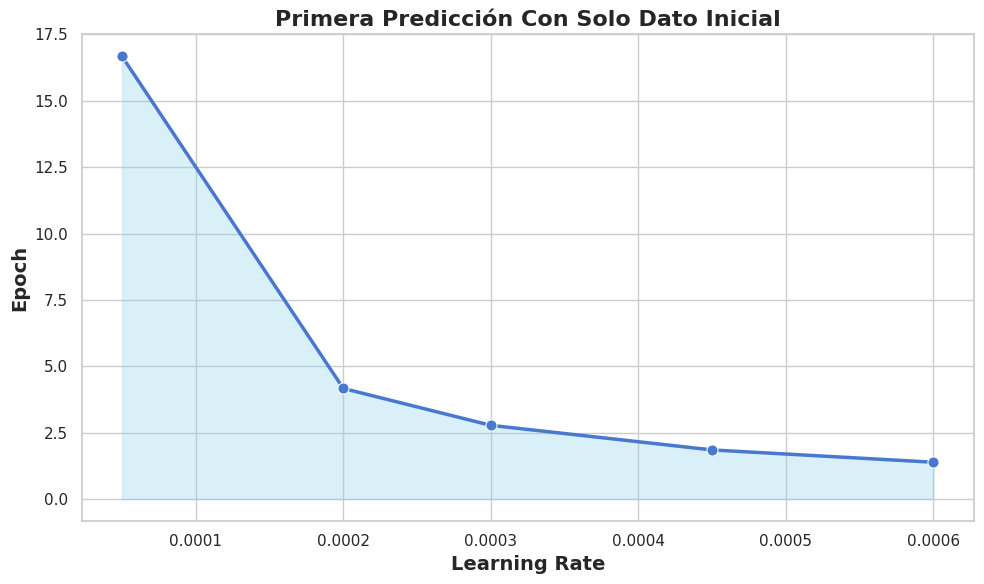

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define the parameters
base_score = 31.5
base_lr = 0.0001

# Learning rates (doubling and quartering)
learning_rates = [0.00005,0.0002,0.0003,0.00045,0.0006]

# Scores with a smooth trend for the plot
scores = [1/0.00005/1200,1/0.0002/1200,1/0.0003/1200,1/0.00045/1200,1/0.0006/1200]

# Set the style and palette for seaborn
sns.set(style="whitegrid", palette="muted")

# Create the plot
plt.figure(figsize=(10, 6))

# Plot with seaborn style
sns.lineplot(x=learning_rates, y=scores, marker="o", linewidth=2.5, markersize=8)

# Fill the area under the curve with a light color
plt.fill_between(learning_rates, scores, color="skyblue", alpha=0.3)
plt.xscale('log')
# Customize the x-axis to logarithmic scale

# Add labels and title
plt.xlabel('Learning Rate', fontsize=14, fontweight='bold')
plt.ylabel('Epoch', fontsize=14, fontweight='bold')
plt.title('Primera Predicción Con Solo Dato Inicial', fontsize=16, fontweight='bold')

# Show the plot with tight layout
plt.tight_layout()
plt.show()


import numpy as np
import pandas as pd
import xarray as xr

# Assuming you already have sst_train loaded
sst_train, nino_train, sst_eval, nino_eval, sst_test, nino_test = prepare_data('/content/gdrive/MyDrive/Tesis_Tito/codigo/earthformerDependecies/datasets/icar_enso_2021/enso_round1_train_20210201')

sst_train = sst_train[0][0]
# Print the shape to confirm it's (1836, 24, 48, 15)
model_1 = sst_train[:, :, 0]
model_2 = sst_train[:, :, 1]

latitudes = np.arange(-55, 61, 5)  # Latitude from -55 to 60 with a gap of 5
longitudes = np.arange(95, 331, 5)  # Longitude from 95 to 330 with a gap of 5
# Create latitudes as row indices

# Create DataFrames for each model
df_model_1 = pd.DataFrame(model_1, index=latitudes, columns=longitudes)
df_model_2 = pd.DataFrame(model_2, index=latitudes, columns=longitudes)

# Display the tables

df_model_1.head(100)



# Clean up by deleting variables if needed
del sst_train
del nino_train
del sst_eval

df_model_2.round(2).head(-5)
